In [3]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100
import numpy as np
import torch
from pkg_resources import packaging
import torchvision

#print("Torch version:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"


clip.available_models()
model, preprocess = clip.load('RN50', device,jit=False)

In [4]:
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function load.<locals>.<lambda> at 0x7f1d6d388ee0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [26]:

import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import OrderedDict
import torch
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

"""
df = pd.read_csv('bert_result.csv')
descriptions = df.head(5).set_index('Name').to_dict()['Description']
print(descriptions)
"""

descriptions = {

"asian-chicken-and-cabbage-salad-51160620": "Pat chicken dry with paper towels, season all over with 2 tsp. salt, and tie legs together with kitchen twine.",
"asiago-cheese-with-glazed-cipolline-onions-355871": "Preheat oven to 400°F and line a rimmed baking sheet with parchment. In a large bowl, whisk the egg whites until foamy (there shouldn’t be any liquid whites in the bowl).",
"asiago-pepper-frico-235138": "Place a rack in middle of oven; preheat to 400°. Bring evaporated milk and whole milk to a bare simmer in a large saucepan over medium heat."
}



/tmp/ipykernel_1956982/325831099.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


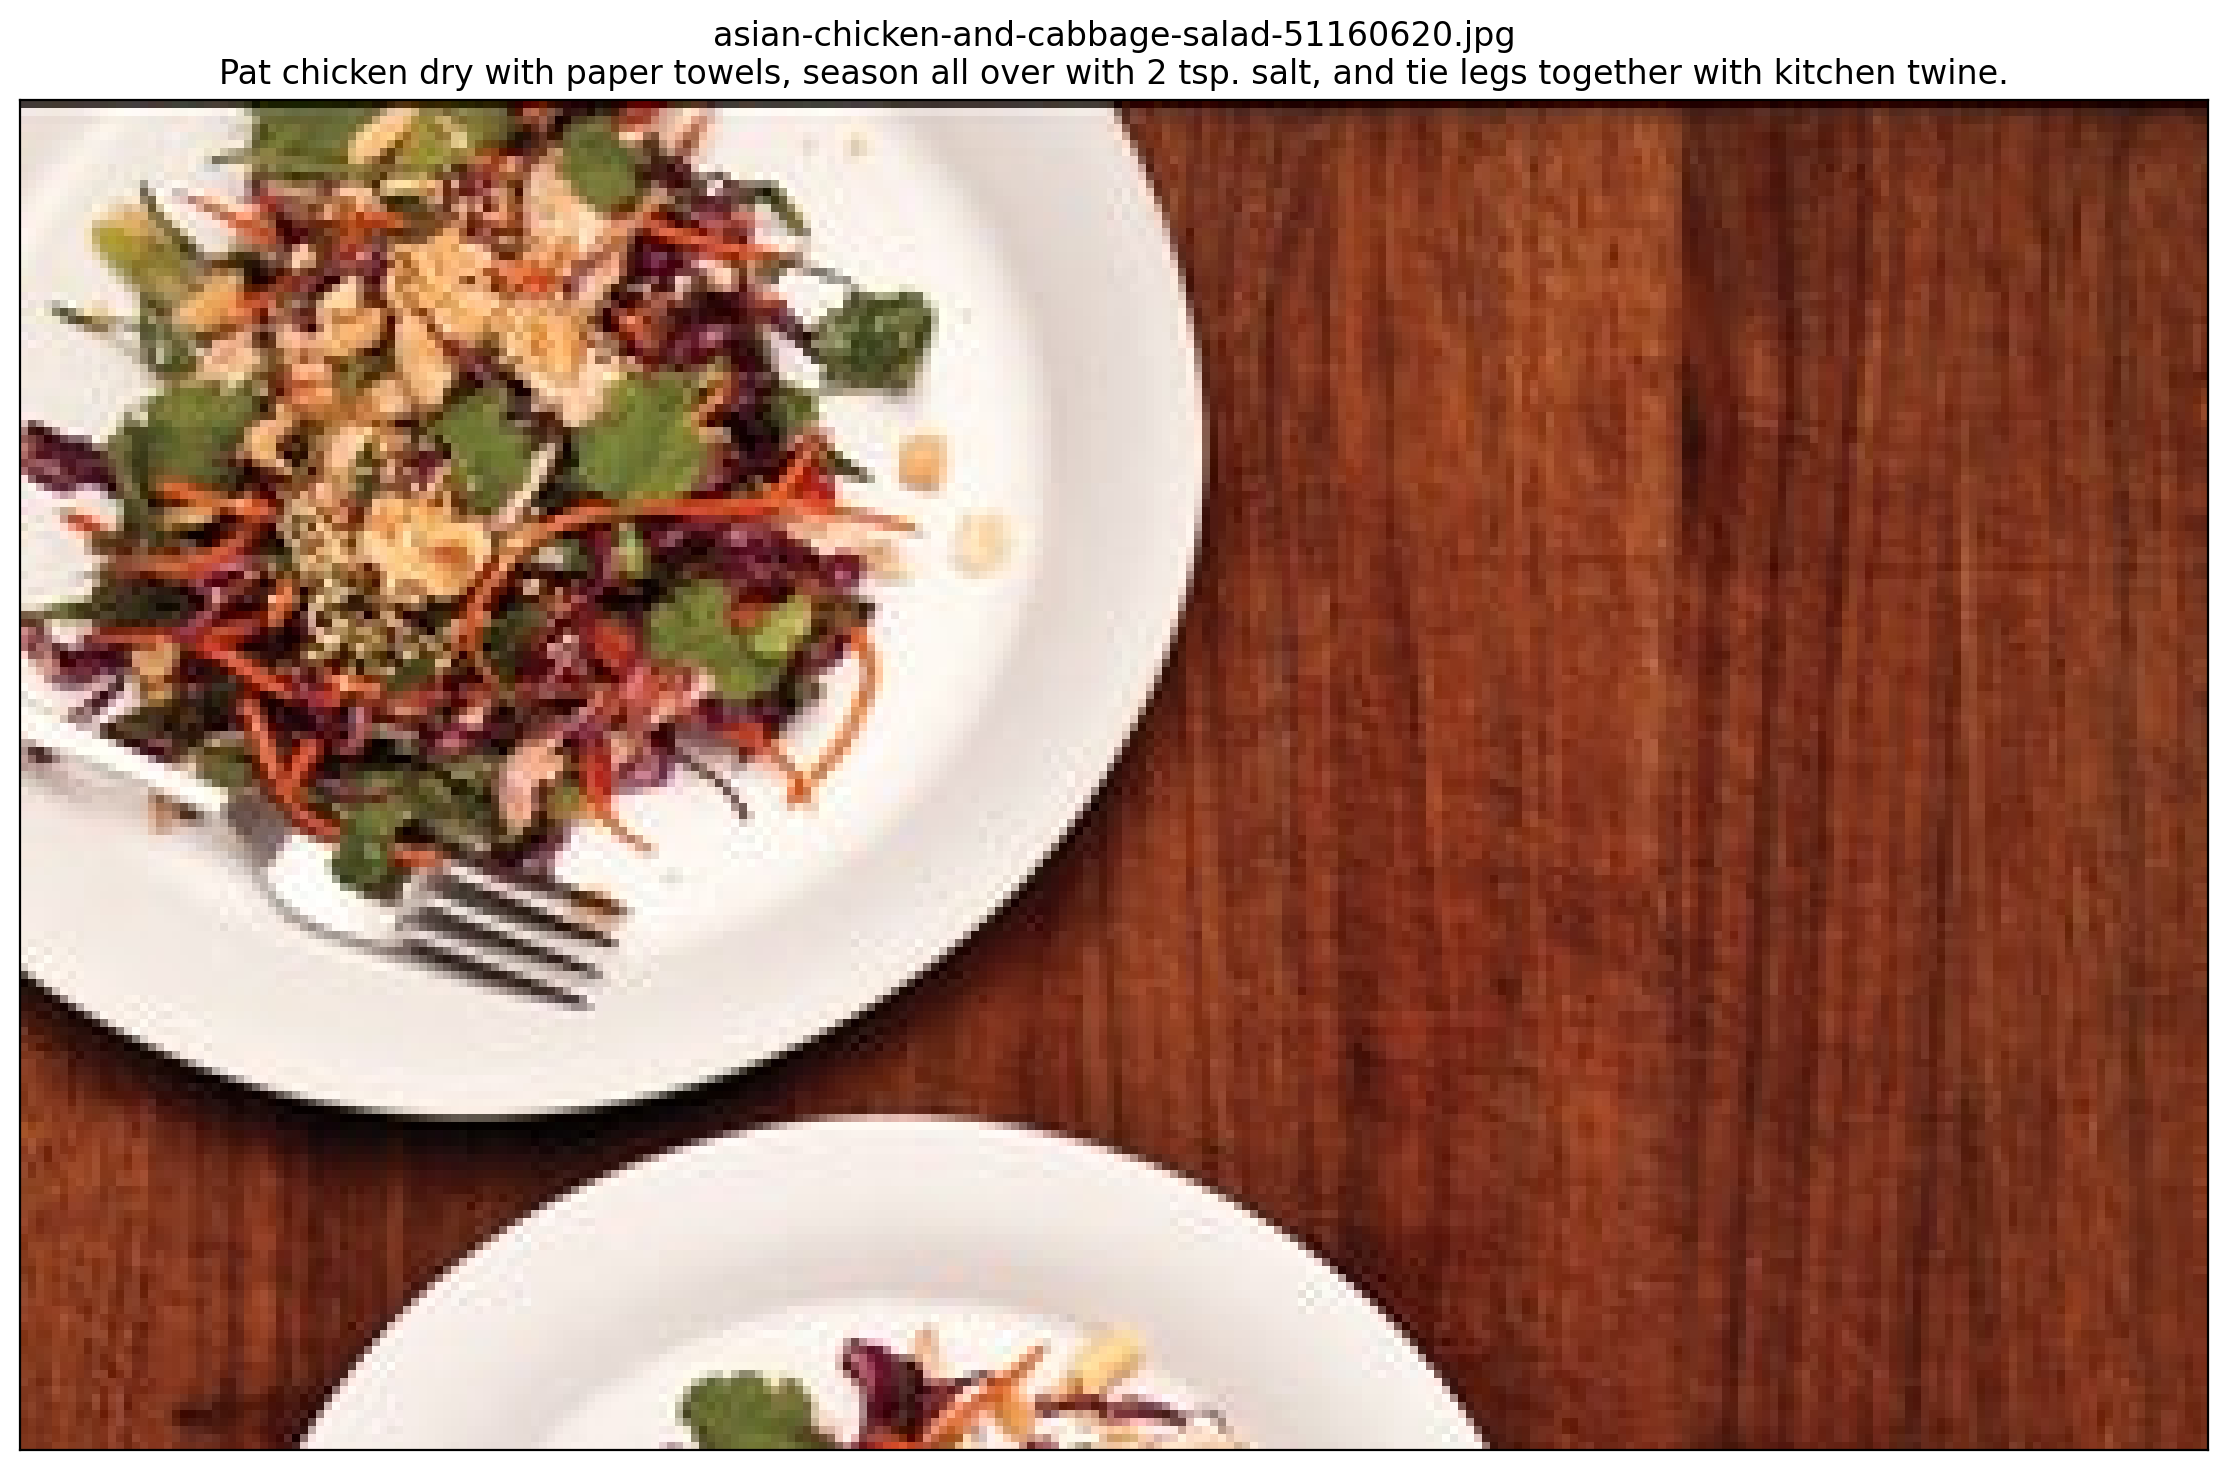

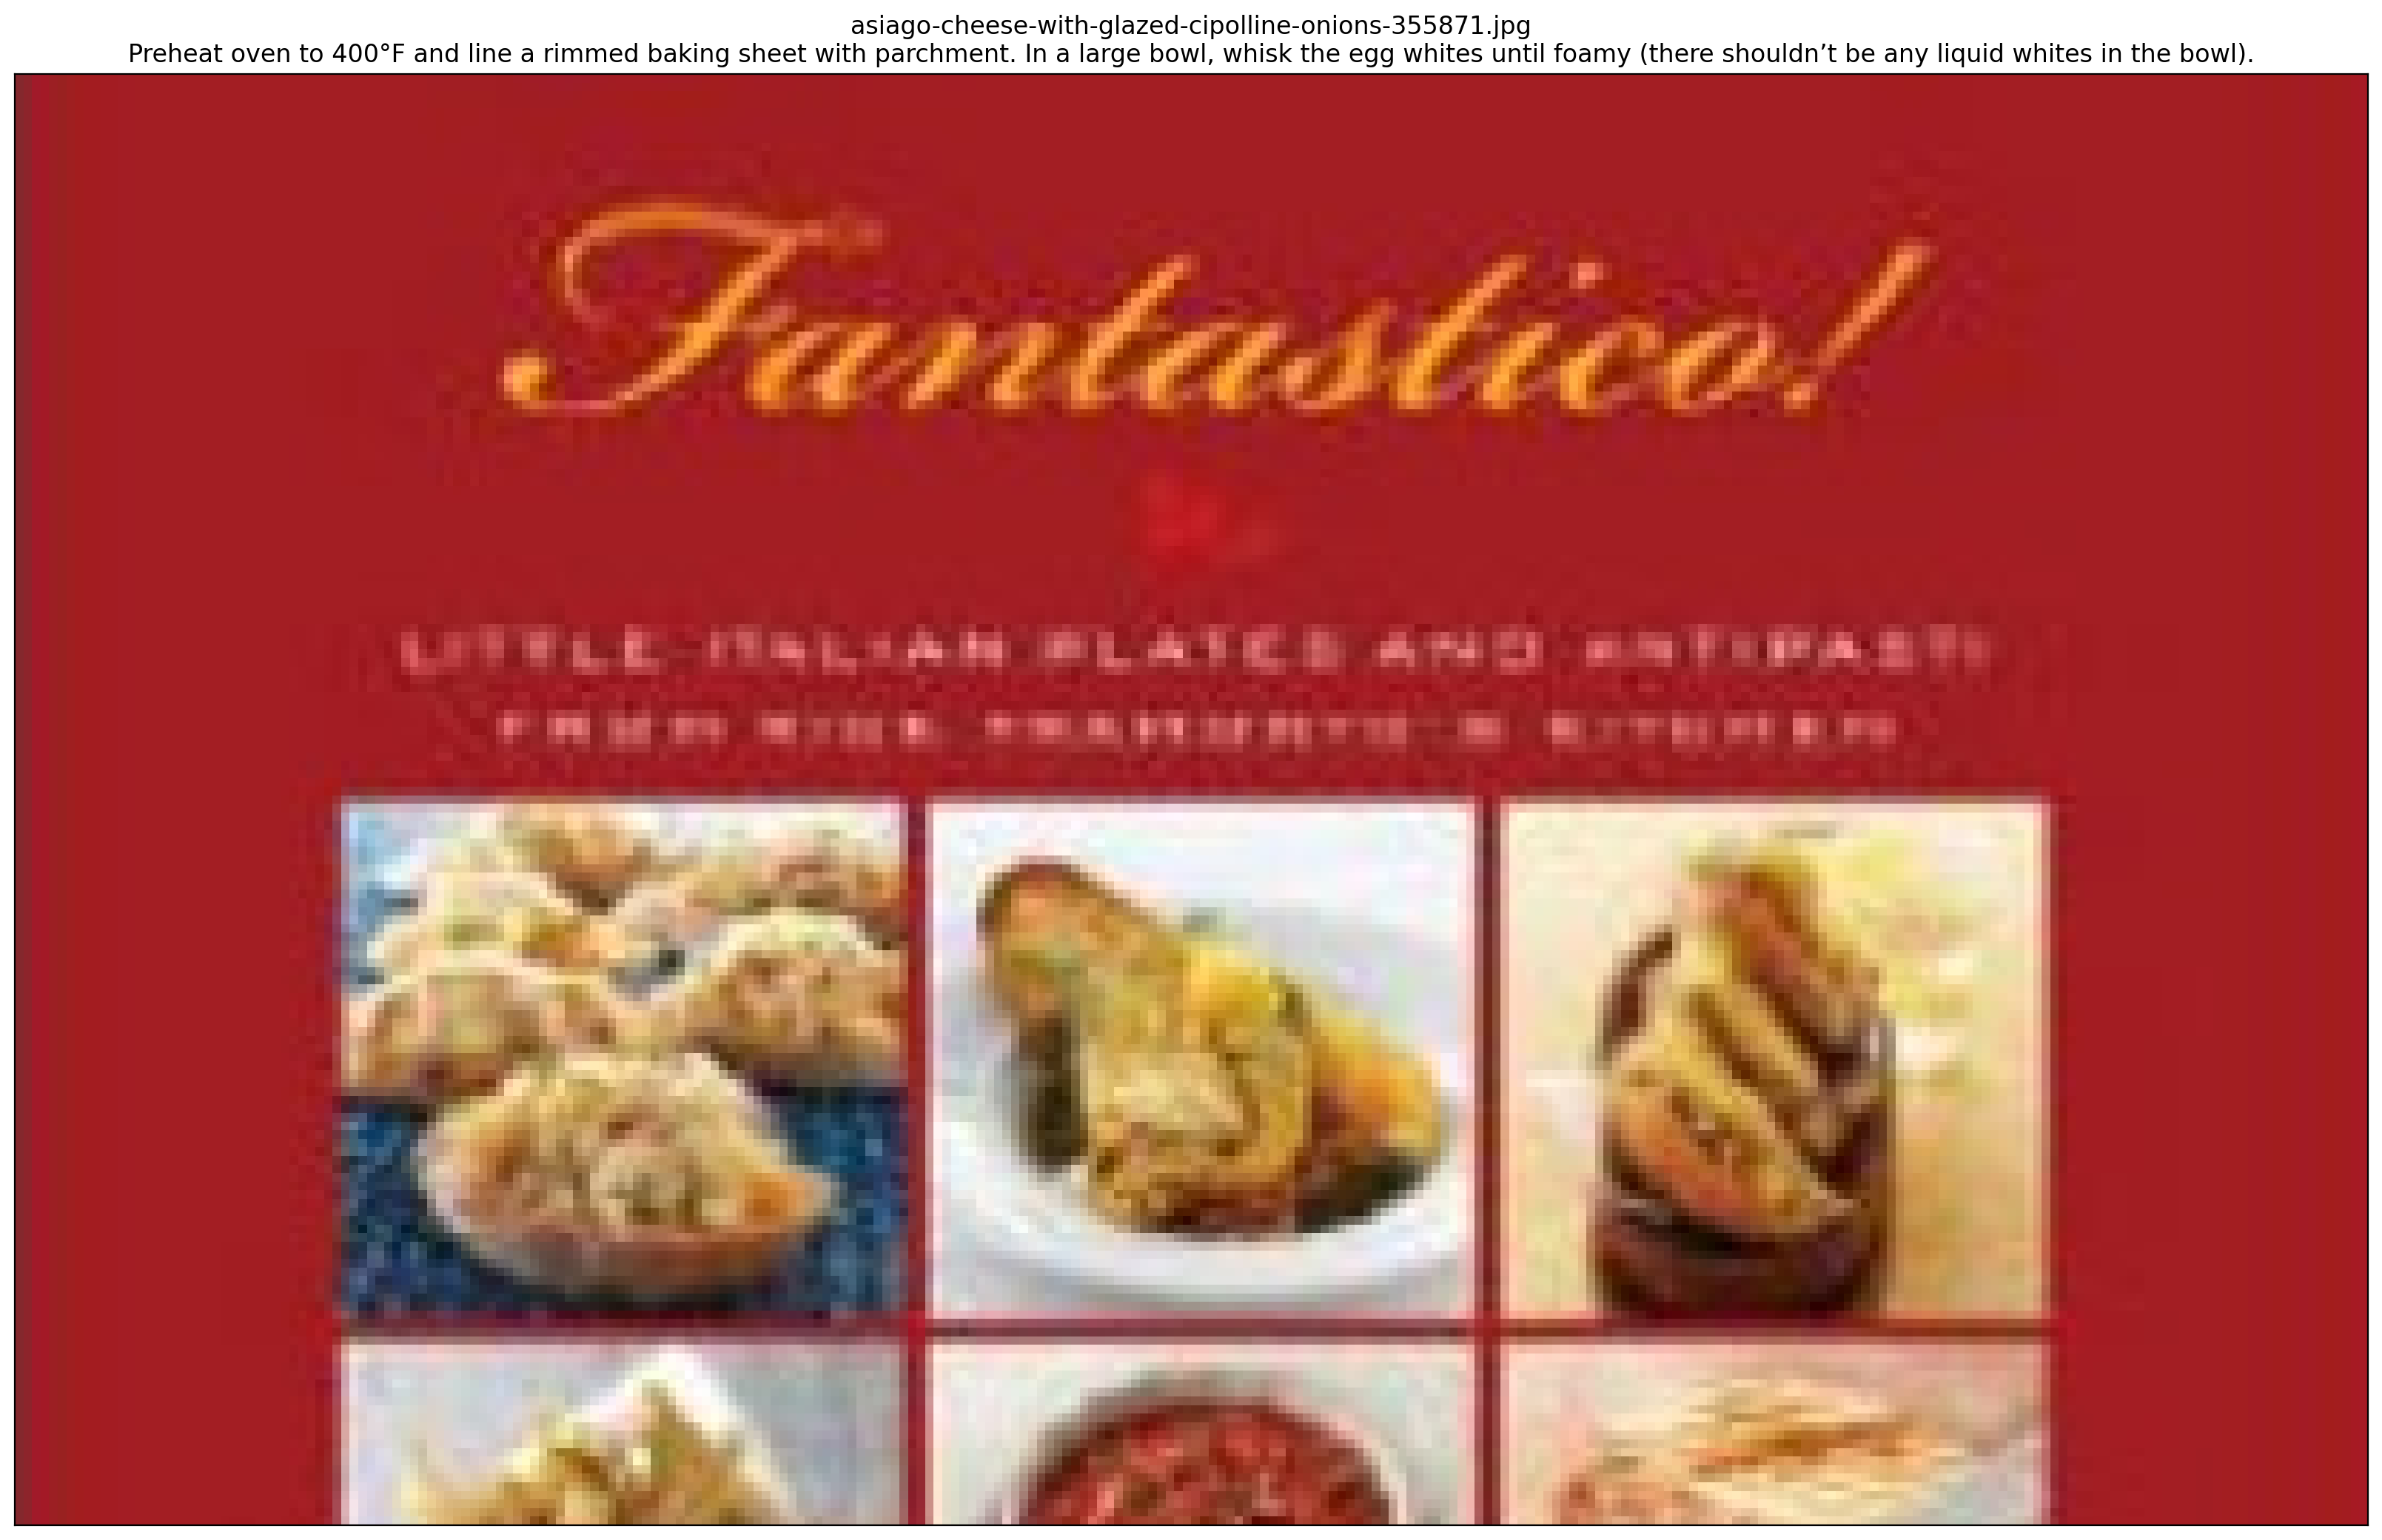

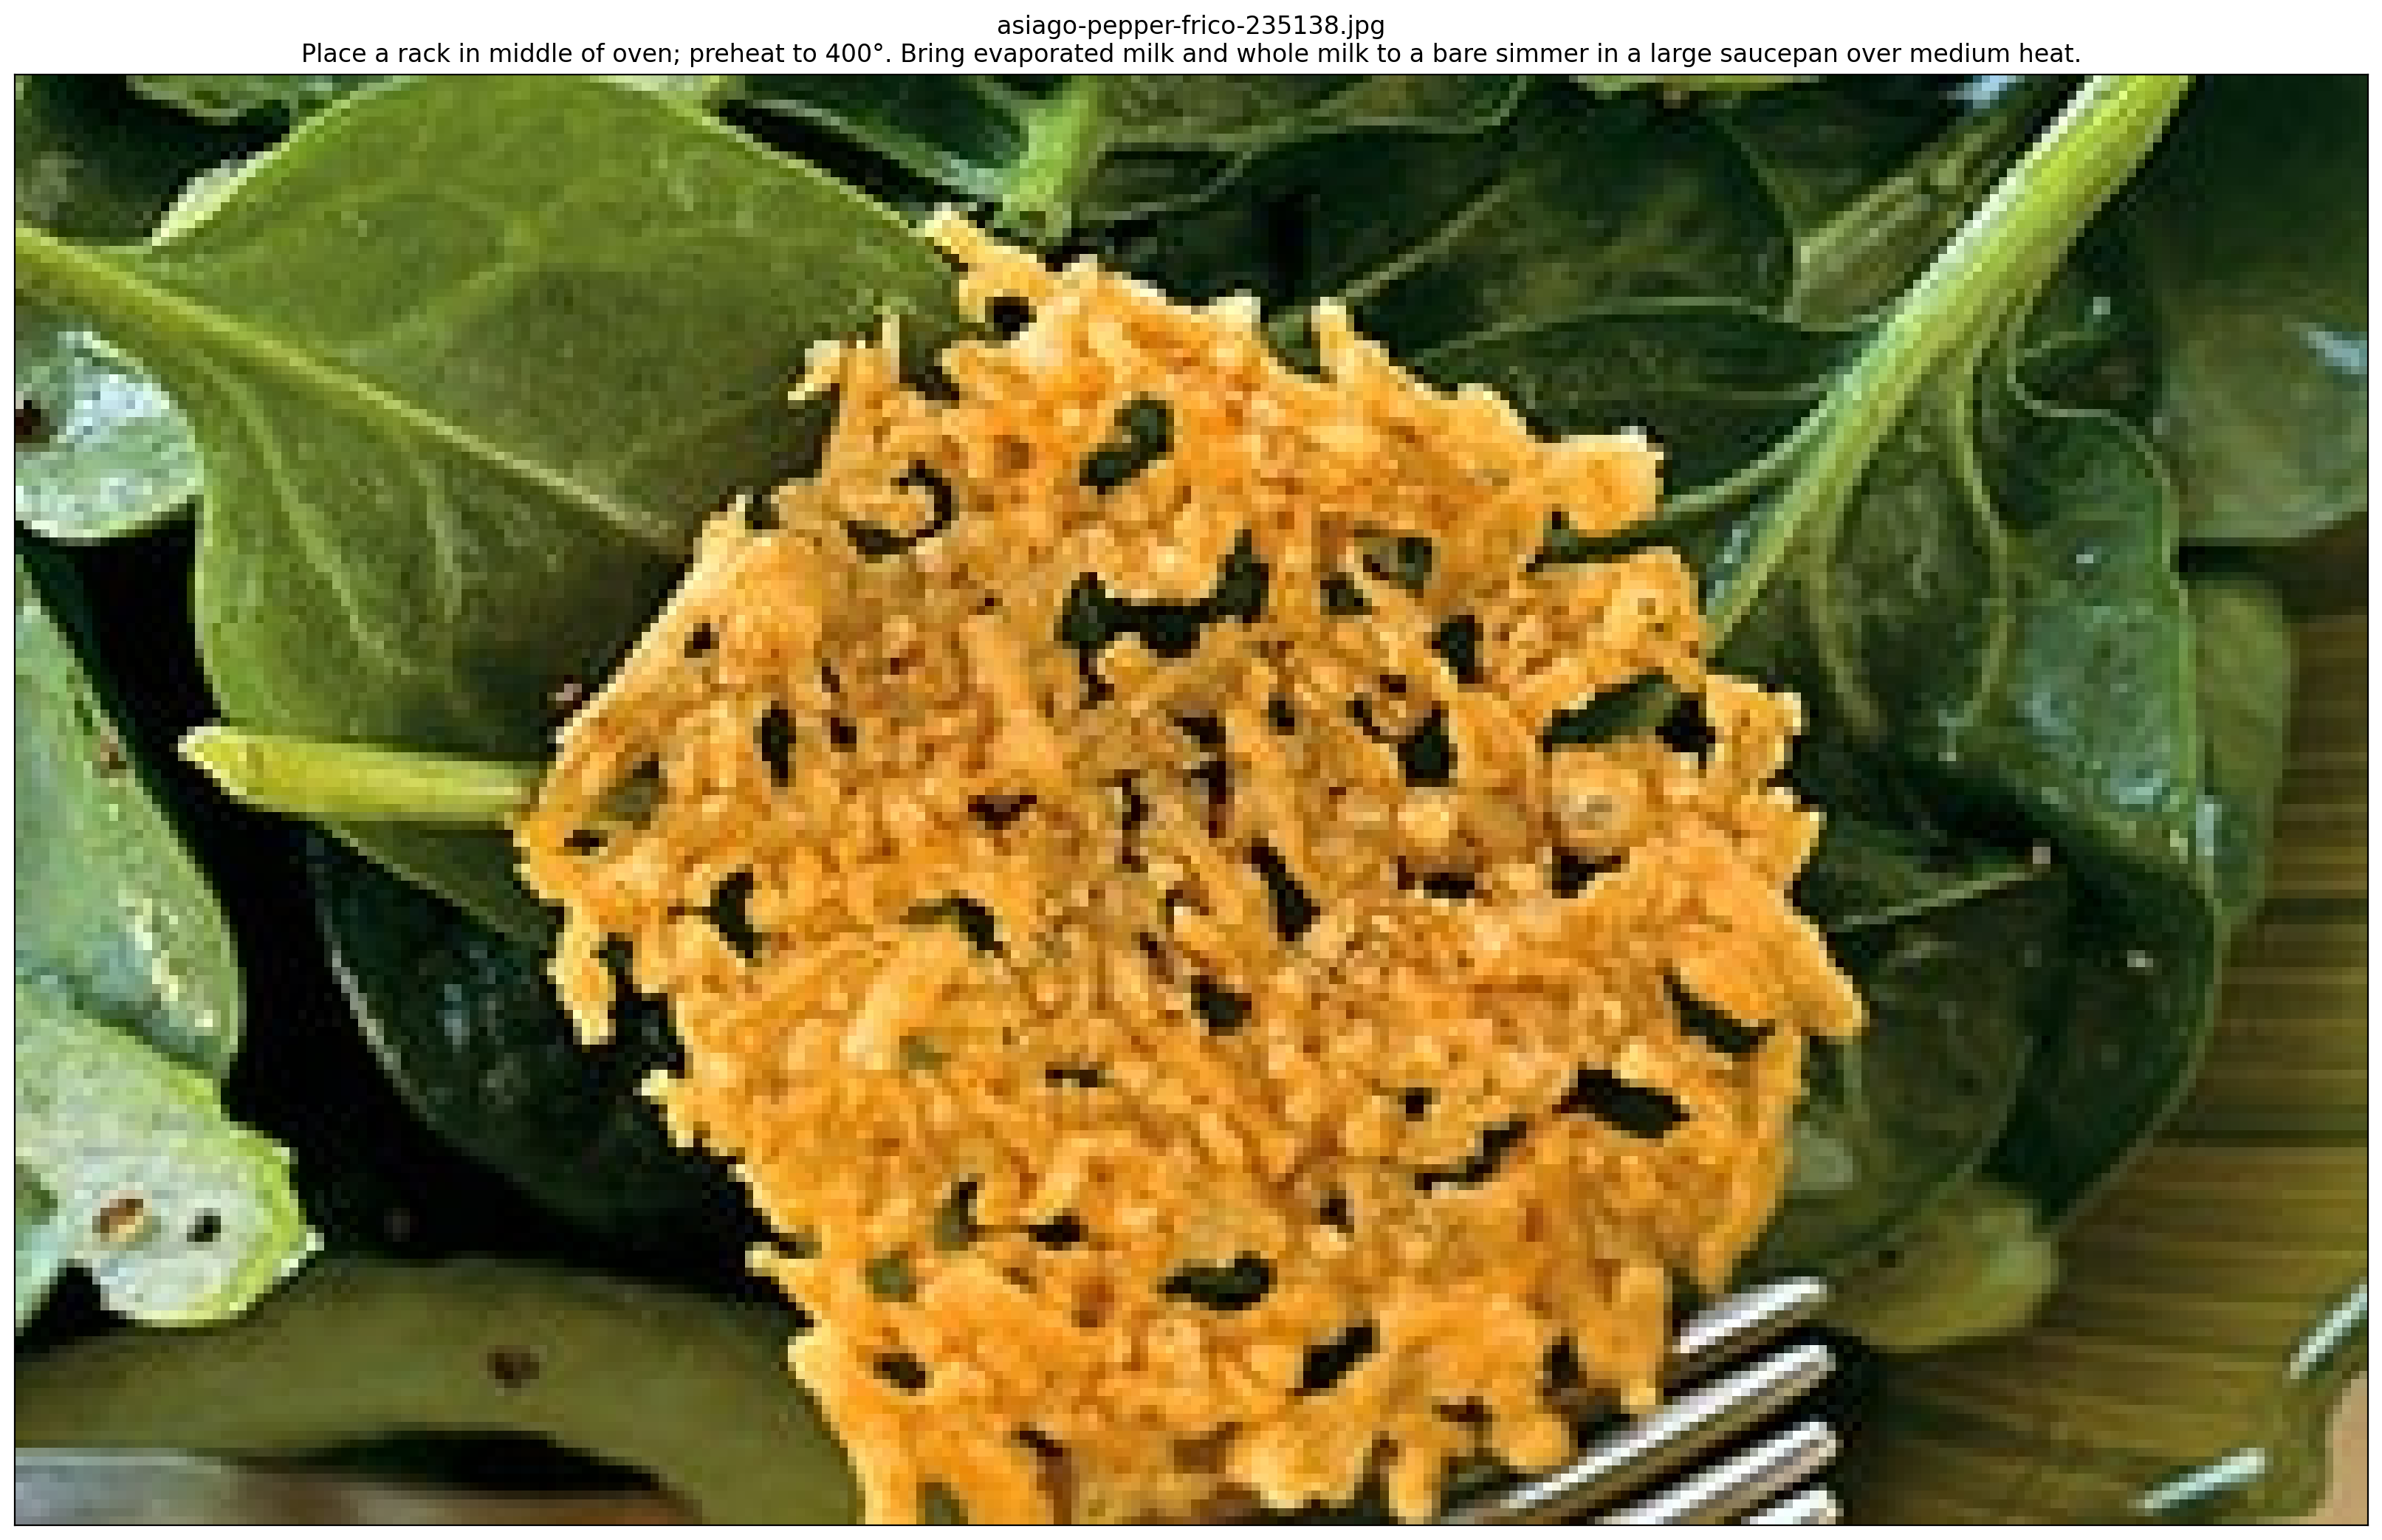

<Figure size 4800x1500 with 0 Axes>

In [27]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

images_directory_path = 'data_recipe/Food Images/Food Images'

for i, filename in enumerate([filename for filename in os.listdir(images_directory_path) if filename.endswith(".png") or filename.endswith(".jpg")][:3]):
    name = os.path.splitext(filename)[0]
    #print(name)
    if name not in descriptions:
        continue

    image_path = os.path.join(images_directory_path, filename)
    image = Image.open(image_path).convert("RGB")

     # Afficher l'image
    plt.subplot(1, 3, len(images) + 1)  # Ajustez le nombre de colonnes selon vos besoins
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")  # Remplacez 'Description here' par vos descriptions
    plt.xticks([])
    plt.yticks([])
    plt.figure(figsize=(16, 5), constrained_layout=True)

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

In [28]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()
     
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

/users/eleves-b/2022/hanna.mergui/Computer-Vision/.venv/lib64/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:78.)
  return F.conv2d(input, weight, bias, self.stride,


Text(0.5, 1.0, 'Cosine similarity between text and image features')

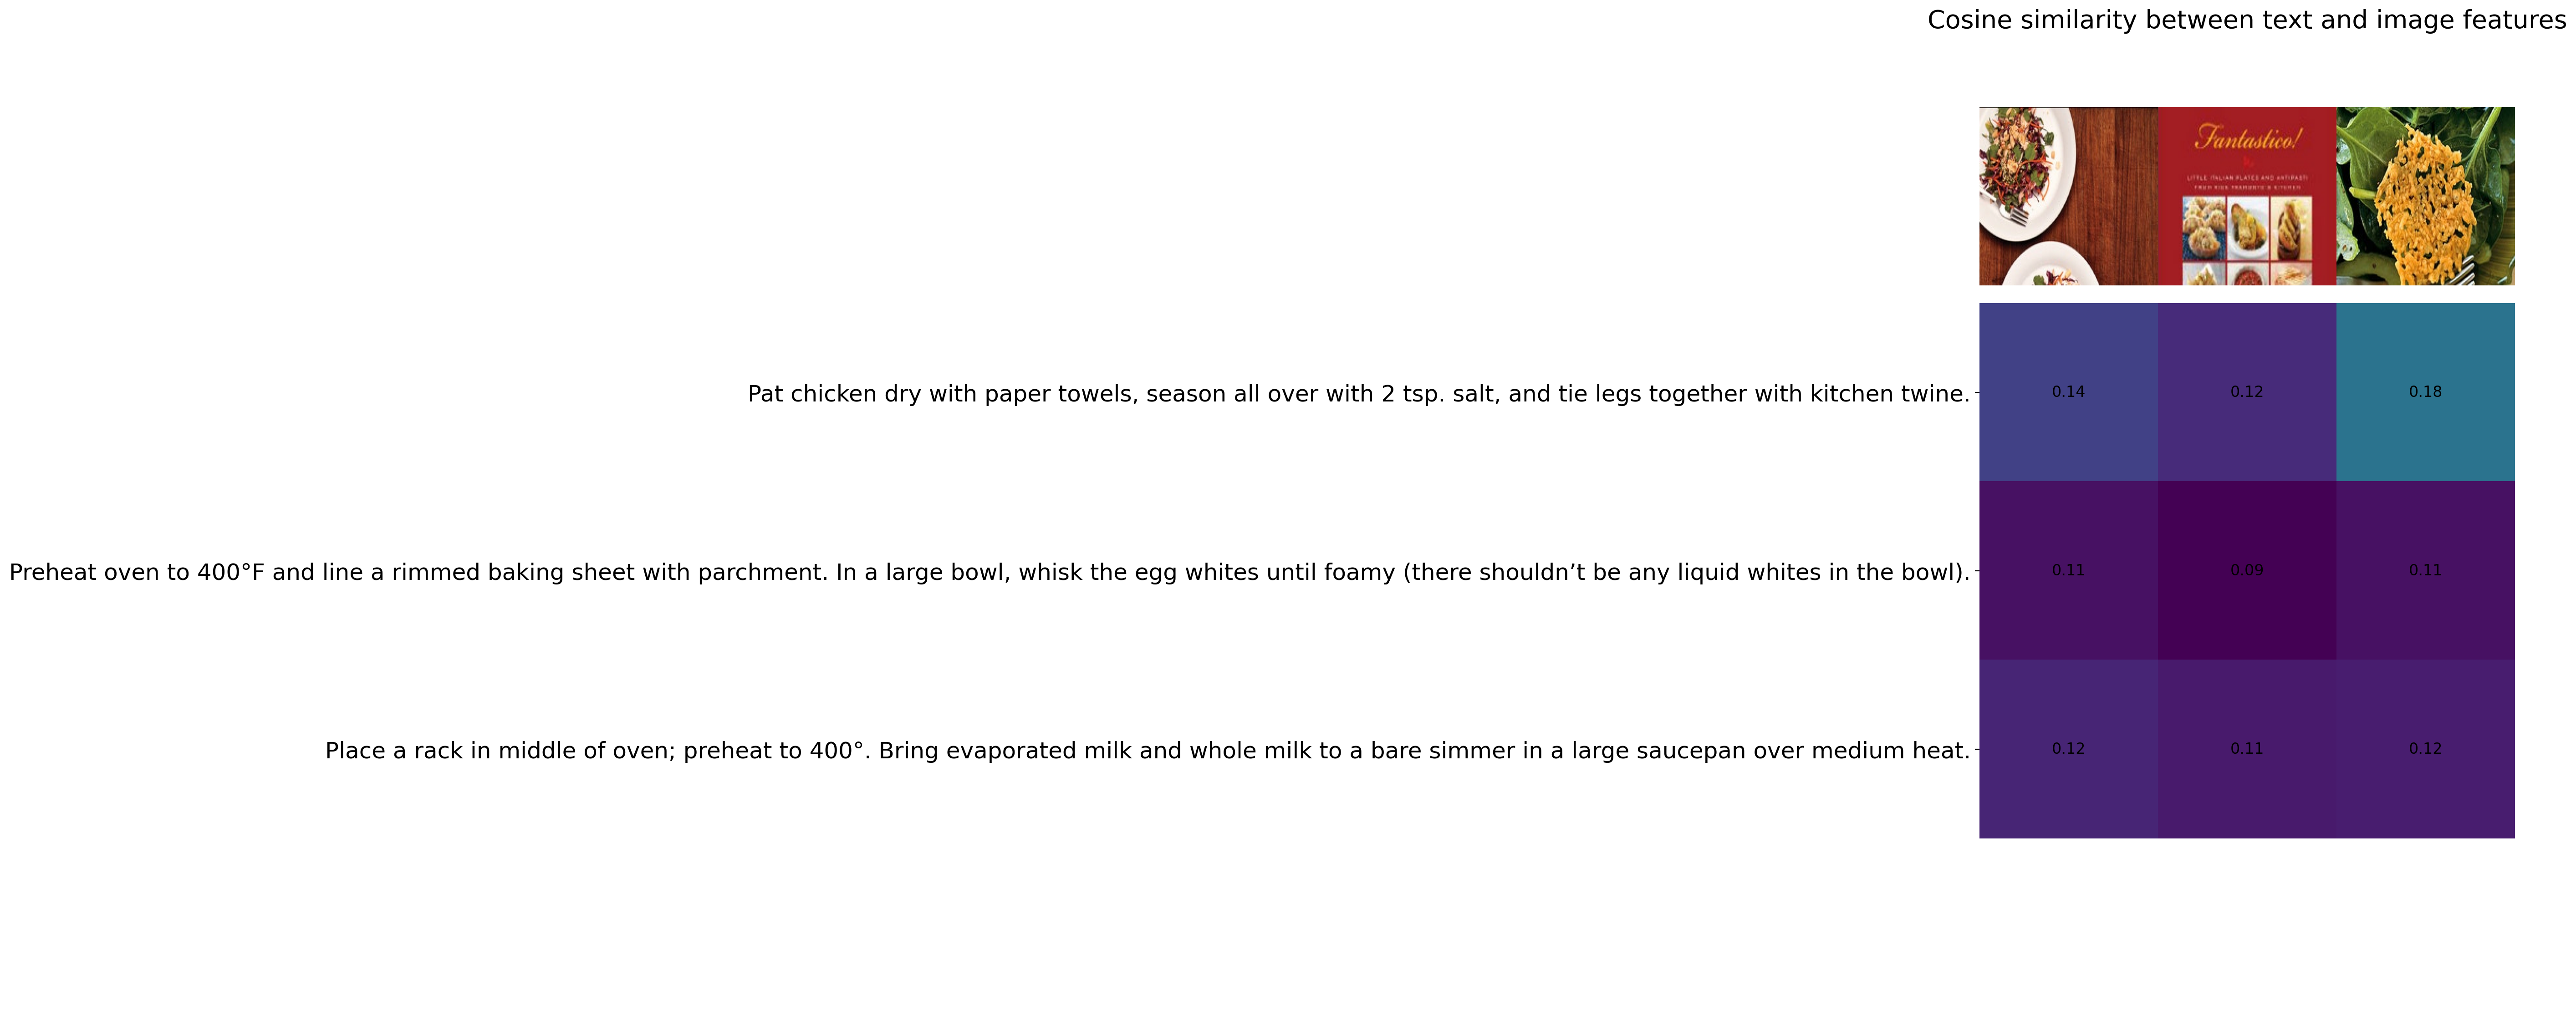

In [29]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
     
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)